# Explore differences between topography products:
## Compare GEBCO Bedmachine, IBcso, etc.

In [2]:

import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os
import sys
import xarray as xr
import scipy.io as sio
import datetime
import cmocean
# import h5py
import bathy_smoother
# import pyresample

#proj_dir = os.path.join(os.pardir,os.pardir)
proj_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(proj_dir,'data')
src_dir = os.path.join(proj_dir,'src')

sys.path.append(src_dir)

from ext.tools.inverse_polar_stereo import inverse_polar_stereo
from ext.tools.cartesian_grid_2d import haversine
from ext.tools.NDinterp import NDinterp
from ext.tools.smoothing_PlusMinus_rx0 import smoothing_PlusMinus_rx0
from ext.tools.uvp_masks import uvp_masks

# %load_ext autoreload
# %autoreload 1
# %aimport tools.inverse_polar_stereo,tools.cartesian_grid_2d,tools.NDinterp,tools.smoothing_PlusMinus_rx0,tools.uvp_masks



In [3]:
GridStyle='pureGeo'
if GridStyle=='xyToGeo':
    mr = 2
    grid_xLims= (1500,2500) #km
    grid_yLims= (400,1500) #km
    #establish the grid with grid point distances of mr/2 in km
    #we need double resolution to cover all of the staggered grid points (we subset to rho, psi, u, v points later)
    #we need an extra line of u and v points at first to calculate all dx and dy on rho points
    x,y = np.meshgrid(np.arange(grid_xLims[0],grid_xLims[1]+mr/2,mr/2),np.arange(grid_yLims[0],grid_yLims[1]+mr/2,mr/2))

    lat,lon = inverse_polar_stereo(x,y,0,0,-71.0)
elif GridStyle=='pureGeo':
    lon,lat = np.meshgrid(np.arange(64,80,.05),np.arange(-75,-62,.05))
    
    




In [4]:
#load IBCSOv2 geometry

ibcso_v2_bed = os.path.join(data_dir,'raw','IBCSO_v2','IBCSO_v2_bed.nc')
ibcso_v2_ice = os.path.join(data_dir,'raw','IBCSO_v2','IBCSO_v2_ice-surface.nc')

bed_raw = xr.load_dataset(ibcso_v2_bed)

ice_raw = xr.load_dataset(ibcso_v2_ice)

geom_raw = bed_raw
geom_raw["ice"]=ice_raw.z

#subset bedrock region
geom=geom_raw.sel(x=slice(1e6,3.3e6)).sel(y=slice(0,1.5e6)) # note reversed y coord

# make XX and YY coordinates
XX,YY = np.meshgrid(geom.x,geom.y)
geom = geom.assign_coords({"X": (("y", "x"), XX), "Y": (("y", "x"), YY)})

# convert convert polarstereo to lat/lon and vice versa.
from pyproj import Transformer
from pyproj import CRS
ps_to_ll = Transformer.from_crs( "EPSG:3031","EPSG:4326")
ll_to_ps = Transformer.from_crs( "EPSG:4326","EPSG:3031")
ibcsops_to_ll = Transformer.from_crs( "EPSG:9354","EPSG:4326")

geom_lat,geom_lon = ibcsops_to_ll.transform(geom.X,geom.Y)

geom = geom.assign_coords({"lon": (("y", "x"), geom_lon), "lat": (("y", "x"), geom_lat)})

ibcso2=geom

In [5]:
#load BM3 geometry
bedmachine_v3_path = os.path.join(data_dir,'raw','BedMachineAntarctica-v3','BedMachineAntarctica-v3.nc')

bm3_raw = xr.load_dataset(bedmachine_v3_path)

#subset bedmachine dataset
bm3=bm3_raw.sel(x=slice(1e6,3.3e6)).sel(y=slice(1.5e6,0)) # note reversed y coord

# make XX and YY coordinates
X,Y = np.meshgrid(bm3.x,bm3.y)
bm3 = bm3.assign_coords({"X": (("y", "x"), X), "Y": (("y", "x"), Y)})

bm3_lat,bm3_lon = ps_to_ll.transform(bm3.X,bm3.Y)
bm3 = bm3.assign_coords({"lon": (("y", "x"), bm3_lon), "lat": (("y", "x"), bm3_lat)})

# make 'draft' abd 'bathy' variables
bm3["draft"]=-(bm3.thickness-bm3.surface) #draft is negative
bm3["bathy"]=-bm3.bed # bathy is postive


In [6]:
#load GEBCO 2023 geometry

gebco_2023_bed = os.path.join(data_dir,'raw','GEBCO_2023','GEBCO_2023_sub_ice_topo.nc')

g23 = xr.load_dataset(gebco_2023_bed)

g23 = g23.sel(lon=slice(50,110),lat=slice(-80,-50))
g23

long,latg = np.meshgrid(g23.lon,g23.lat)
g23 = g23.assign_coords({"longitude": (("lat", "lon"), long), "latitude": (("lat", "lon"), latg)})

<Figure size 640x480 with 0 Axes>

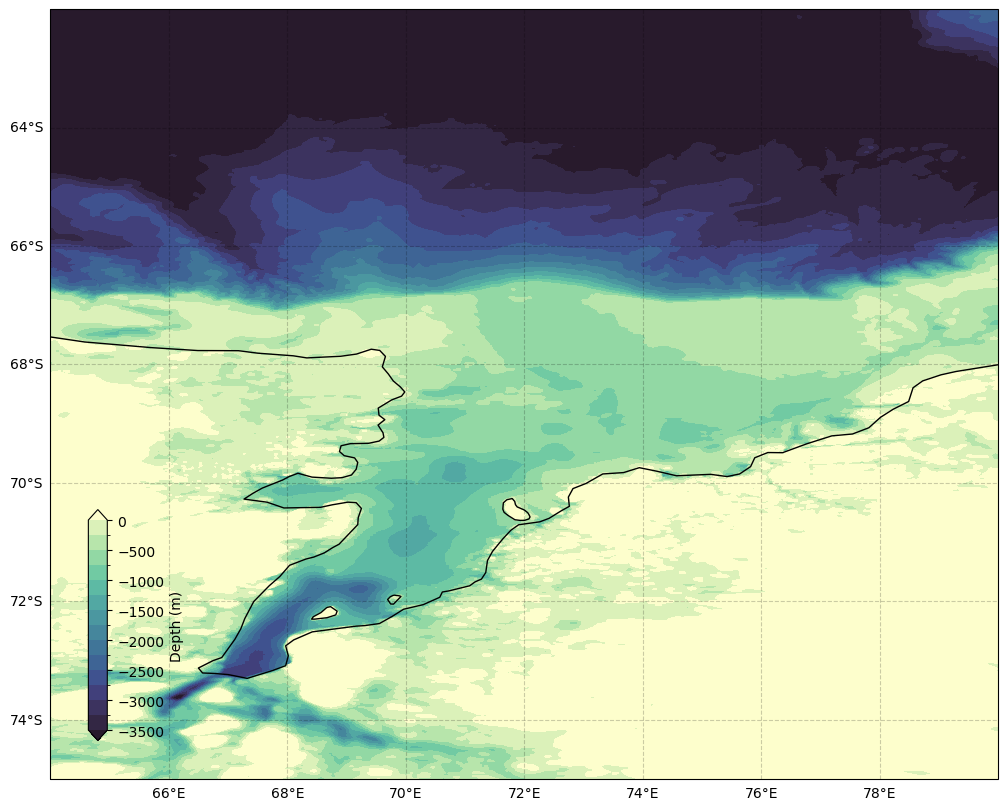

In [7]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='none') # need to find a better land mask than this.
ax.set_extent([64, 80, -75, -62])

#add data
im = (geom.z).plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3500,250,250)]),add_colorbar=False)

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

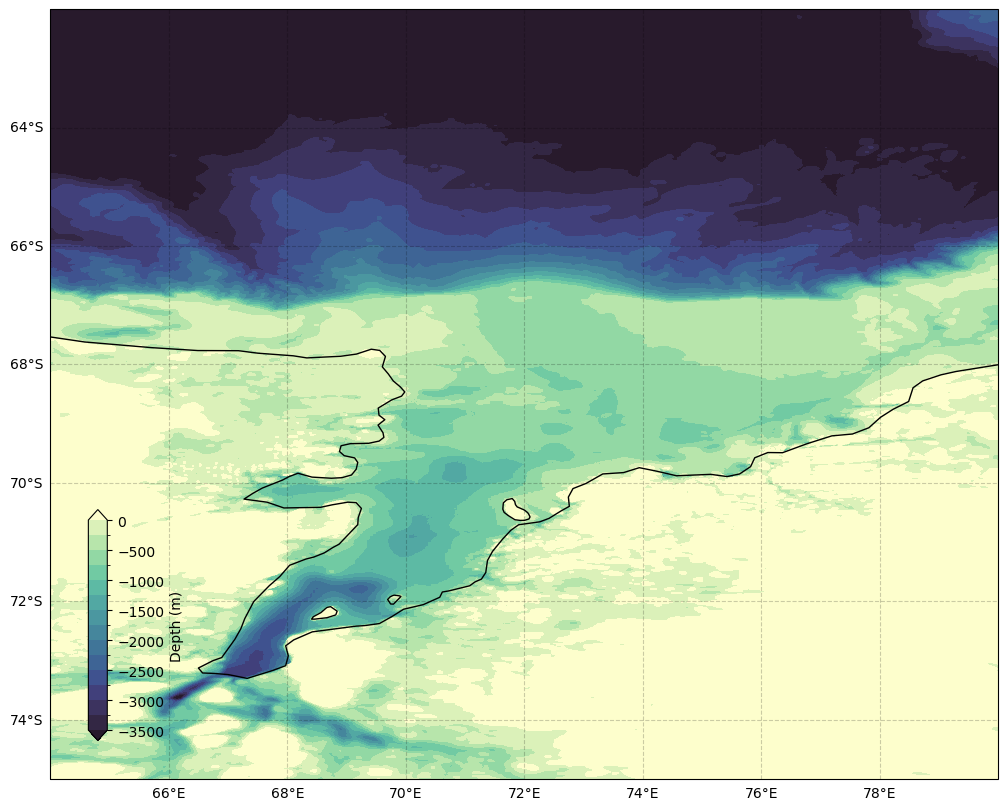

In [8]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='none') # need to find a better land mask than this.
ax.set_extent([64, 80, -75, -62])

#add data
im = (-bm3.bathy).plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3500,250,250)]),add_colorbar=False)

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


<Figure size 640x480 with 0 Axes>

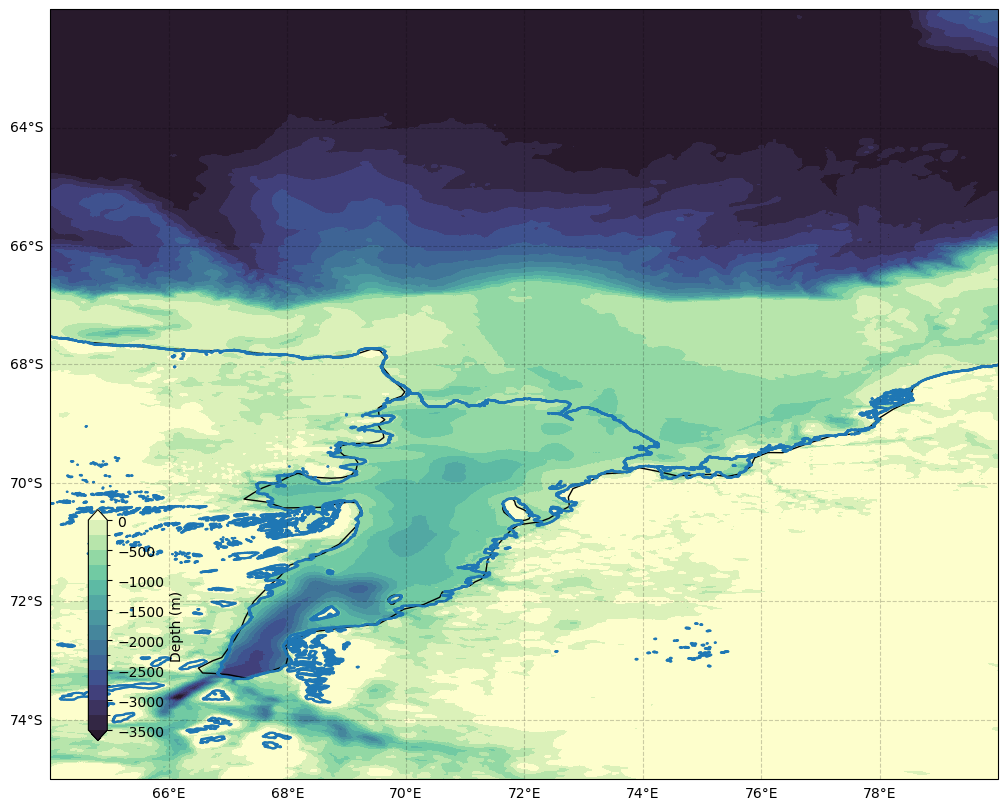

In [9]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
feature = ax.add_feature(Coast,edgecolor='black',facecolor='none') # need to find a better land mask than this.
ax.set_extent([64, 80, -75, -62])

#add data
im = (g23.elevation).plot.contourf(x='lon',y='lat',cmap='cmo.deep_r',levels=np.array([*np.arange(-3500,250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C0')

#add colourbar
cax = inset_axes(ax,
                width="2%",  # width = 10% of parent_bbox width
                height="30%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.04,.05, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Depth (m)')
ax = plt.gca()

plt.show()


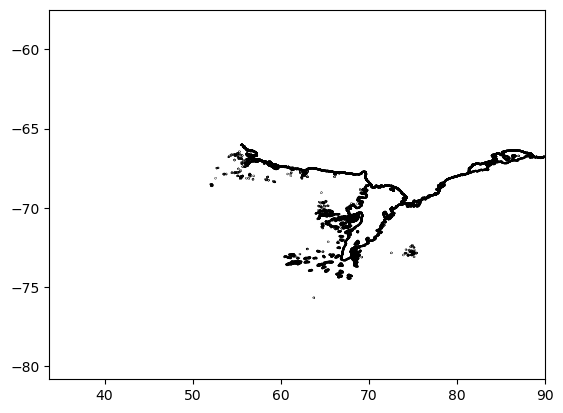

In [10]:
plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='k')


In [11]:
# interpolate from the geometry grid to the new roms grid

from scipy.interpolate import griddata

comp={}
comp_ibcso2=griddata((ibcso2['lon'].values.flatten(),ibcso2['lat'].values.flatten()),ibcso2['z'].values.flatten(),(lon,lat),'nearest')
comp_gebco2023=griddata((g23['longitude'].values.flatten(),g23['latitude'].values.flatten()),g23['elevation'].values.flatten(),(lon,lat),'nearest')


/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contour(*args, **kwargs)
/home/woden/miniconda3/envs/devel3.10/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:1614: UserWarning: The following kwargs were not used by contour: 'add_colorbar'
  result = super().contour(*args, **kwargs)


<Figure size 640x480 with 0 Axes>

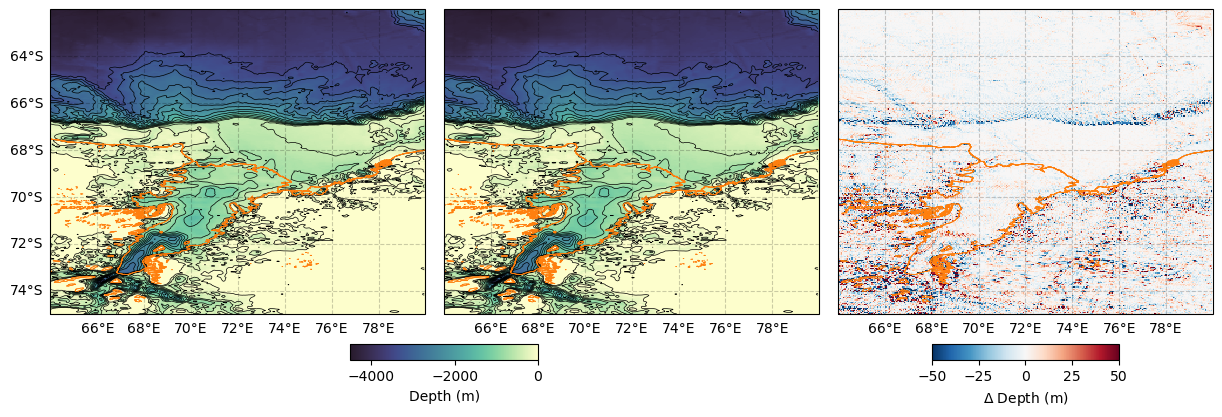

: 

In [23]:

# Create a plot of the bathymetry data using Cartopy
gs = gridspec.GridSpec(nrows=1,ncols=3,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,10])
ax = None

#make an axis and decorate the cartopy stuff
ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
# Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
# feature = ax.add_feature(Coast,edgecolor='black',facecolor='none') # need to find a better land mask than this.
ax.set_extent([64, 80, -75, -62])

#add data
im = plt.pcolormesh(lon,lat,comp_ibcso2,cmap='cmo.deep_r',vmin=-4500,vmax=0)
co = plt.contour(lon,lat,comp_ibcso2,colors='k',levels=np.array([*np.arange(-3500,250,250)]),add_colorbar=False,extend='both',linewidths=0.5,linestyles='-')
gl=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C1',linewidths=0.5)

#add colourbar
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.8,-.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax,orientation='horizontal') 
cbar.set_label('Depth (m)')
ax = plt.gca()

###
ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
# feature = ax.add_feature(Coast,edgecolor='black',facecolor='none') # need to find a better land mask than this.
ax.set_extent([64, 80, -75, -62])

im = plt.pcolormesh(lon,lat,comp_gebco2023,cmap='cmo.deep_r',vmin=-4500,vmax=0)
co = plt.contour(lon,lat,comp_gebco2023,colors='k',levels=np.array([*np.arange(-3500,250,250)]),add_colorbar=False,extend='both',linewidths=0.5,linestyles='-')
gl=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C1',linewidths=0.5)

###
ax = fig.add_subplot(gs[0,2], projection=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
# Coast = cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none',name='coastline')
# feature = ax.add_feature(Coast,edgecolor='black',facecolor='none') # need to find a better land mask than this.
ax.set_extent([64, 80, -75, -62])

im = plt.pcolormesh(lon,lat,comp_ibcso2-comp_gebco2023,cmap='RdBu_r',vmin=-50,vmax=50)#,levels=np.array([*np.arange(-3500,250,250)]),add_colorbar=False)
co=plt.contour(bm3.lon,bm3.lat,bm3.mask,colors='C1',linewidths=0.5)

#add colourbar
cax = inset_axes(ax,
                width="50%",  # width = 10% of parent_bbox width
                height="5%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.25,-.15, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax,orientation='horizontal') 
cbar.set_label('$\Delta$ Depth (m)')
ax = plt.gca()

